In [1443]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
from itertools import product
from qutip.qip.operations import rz, cz_gate

#experimental values borrowed from 
# https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010
qbta = scq.Fluxonium(
    EC = 1.5,
    EJ = 5.5,
    EL = 1.0,
    flux = .5, #flux frustration point
    cutoff = 110,
    truncated_dim = 10
)

qbtb = scq.Fluxonium(
    EC = 1.2,
    EJ = 5.7,
    EL = 1.0,
    flux = .5,
    cutoff = 110,
    truncated_dim = 10
)

hilbertspace = scq.HilbertSpace([qbta, qbtb])

hilbertspace.add_interaction(
    g_strength = .15,
    op1 = qbta.n_operator,
    op2 = qbtb.n_operator,
    add_hc = True
)

hilbertspace.generate_lookup()

## Drive simulation functions
These functions are taken from the previous tutorial, "Driven composite systems and interface with QuTiP."

In [1444]:
#get the index of a dressed state closed to a subsystem product state
def dressed_index(hilbertspace, *states):
    states_by_index = list(sorted([(hilbertspace.get_subsys_index(sys), state) for (sys, state) in states]))
    return hilbertspace.dressed_index(list(zip(*states_by_index))[1])[0]

#wrap operator in identities and change to dressed eigenbasis
def basis_change(operator, subsystem, hilbertspace, dressed_eigenbasis = True):
    bare_evecs, = hilbertspace.bare_eigenstates(subsystem)
    op_id_wrap = scq.identity_wrap(operator, subsystem, hilbertspace.subsys_list, evecs = bare_evecs)
    evecs, = hilbertspace["evecs"]
    return op_id_wrap.transform(evecs)

total_truncation = 20 #set simulation truncation level

#truncate operators to desdired dimension
def truncate(operator):
    return qt.Qobj(operator[:total_truncation, : total_truncation])

#get the transition frequency between two states specified by dressed indices
def transition_frequency(s0, s1):
    return hilbertspace.energy_by_dressed_index(s1)-hilbertspace.energy_by_dressed_index(s0)

## Drive operators
Get the matrix representations of the drive operators in the dressed eigenbasis

In [1392]:
#resonator drive operator
n_b = basis_change(qbtb.n_operator(), qbta, hilbertspace)
n_b = truncate(n_b) 

In [1393]:
product_states = [(0,0),(0,1),(1,0),(1,1),(1,2)]
idxs = [dressed_index(hilbertspace, (qbta, s1),(qbtb, s2)) for (s1,s2) in product_states]
states = [qt.basis(total_truncation, idx) for idx in idxs]

computational_subspace = states[:4]

In [1411]:
#g0 -> h0 transition
w1112 = transition_frequency(idxs[3], idxs[4])
#h0 -> e1 transition

#Gaussian pulse
A = .014
tg = 500
def drive_coeff(t, args):
    return A*np.exp(-8*t*(t-tg)/tg**2)*np.cos(w1112*t)

evals, = hilbertspace["evals"]
diag_dressed_hamiltonian = qt.Qobj(np.diag(evals), dims = [hilbertspace.subsystem_dims]*2)
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian)

H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [n_b, drive_coeff] #driving through the resonator
]

## Simulation

In [1422]:
tlist = np.linspace(0, 600, 600) #total time

In [1423]:
result = qt.sesolve(H_qbt_drive, qt.basis(20,3), tlist, e_ops = [state*state.dag() for state in states])

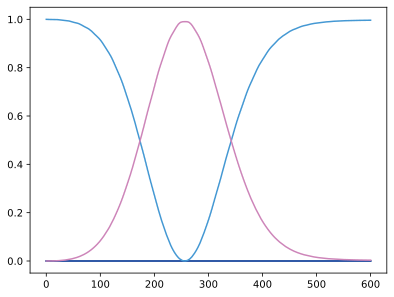

In [1425]:
for res in result.expect:
    plt.plot(tlist, res)

In [1435]:
prop = qt.propagator(H_qbt_drive, tlist)[-1]
Uc = qt.Qobj([[prop.matrix_element(s1, s2) for s1 in computational_subspace] for s2 in computational_subspace])

In [1442]:
def remove_global_phase(op):
    elem = op.data.toarray()[0][0]
    return op*np.conj(elem)

def dphi(state):
    return -np.angle(prop.matrix_element(state, state))+np.angle(prop.matrix_element(states[0],states[0]))

In [1438]:
Uz = remove_global_phase(qt.tensor(rz(dphi(states[2])), rz(dphi(states[1]))))

In [1439]:
Uc_reshaped = qt.Qobj(Uc.data, dims = [[2,2],[2,2]])
Ucprime = remove_global_phase(Uc_reshaped*Uz)
Ucprime

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999118e-01+0.00000000e+00j -2.48462069e-09-4.79136300e-07j
  -6.99140034e-06+4.24988749e-05j -1.41140125e-07+1.31809343e-07j]
 [ 2.51872021e-09-4.79256819e-07j  9.99997718e-01+0.00000000e+00j
   1.75319619e-06+3.15000494e-08j -7.11620187e-06-5.40373028e-05j]
 [ 6.98641123e-06+4.25459957e-05j -8.74064008e-07+1.59877812e-08j
   9.99902549e-01+0.00000000e+00j  1.50711775e-08+4.85864885e-07j]
 [-1.74168843e-08-9.48896012e-09j -9.90466051e-06+5.37049387e-05j
   3.82252367e-08-4.84907310e-07j -9.96961064e-01-4.93184143e-02j]]

In [1440]:
qt.metrics.process_fidelity(Ucprime, cz_gate())

(0.9968417324797422+0.03685678182936908j)